In [1]:
import os
import scenicplus
import scanpy as sc
import warnings
import pandas as pd
import matplotlib as mpl
import pickle
import dill
import sys

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

work_dir = '/data/leuven/345/vsc34561/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'
local_state_dir = '/data/leuven/338/vsc33838/mirror/state'
motif_path = '/data/leuven/338/vsc33838/mirror/state/motifs/'
scratch_dir = os.getenv('VSC_SCRATCH')
mg_state = os.path.join(os.getenv('VSC_SCRATCH'), 'odc_state')

In [2]:
adata = sc.read_h5ad(os.path.join(mg_state, 'alzheimers.h5ad'))
cistopic_obj = dill.load(open(os.path.join(mg_state, 'cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join( os.path.join(mg_state, 'motifs'), 'menr.pkl'), 'rb'))

We'll filter some of the raw data more aggressively.

In [3]:
adata = adata.raw.to_adata()

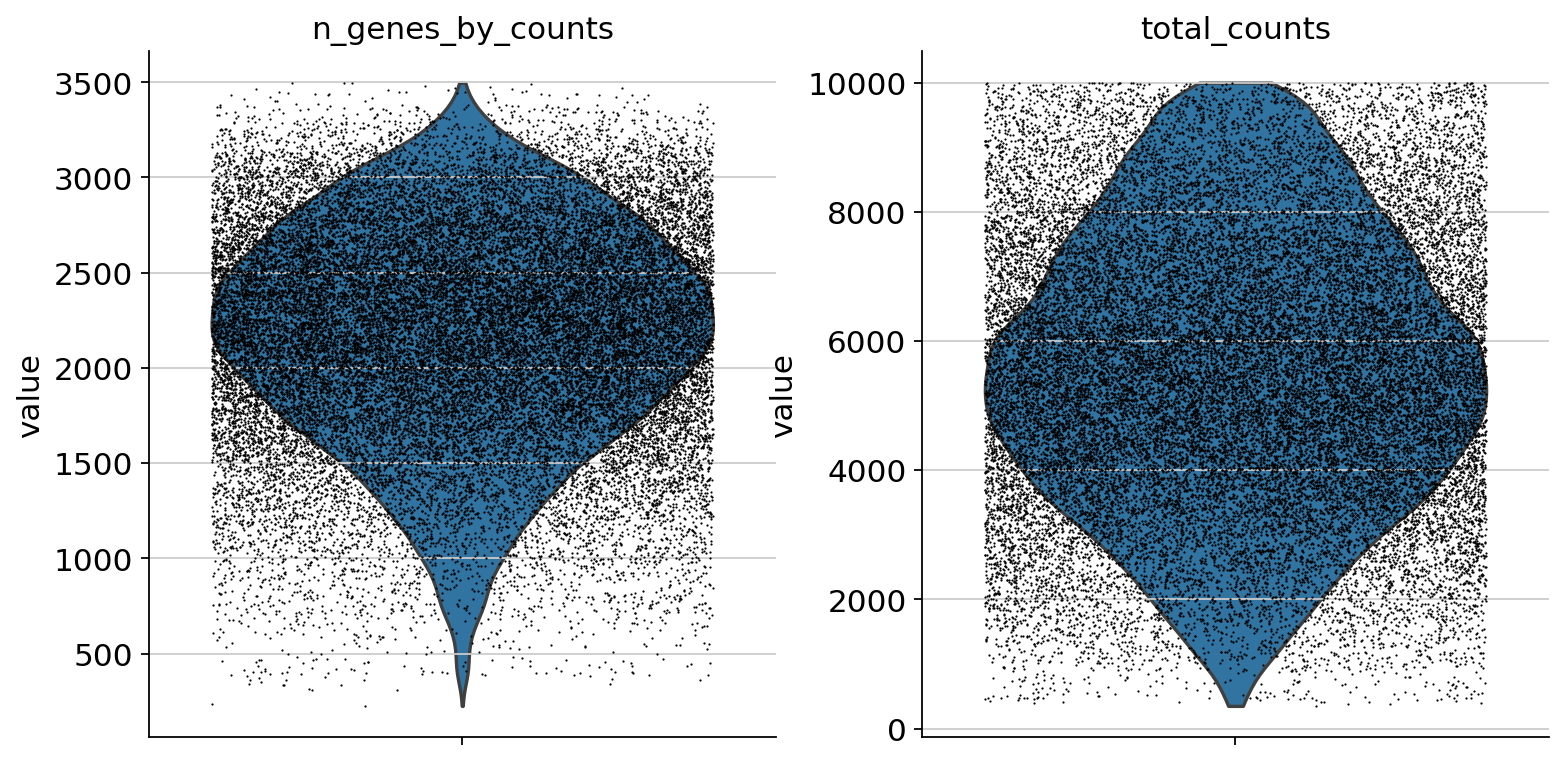

In [4]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

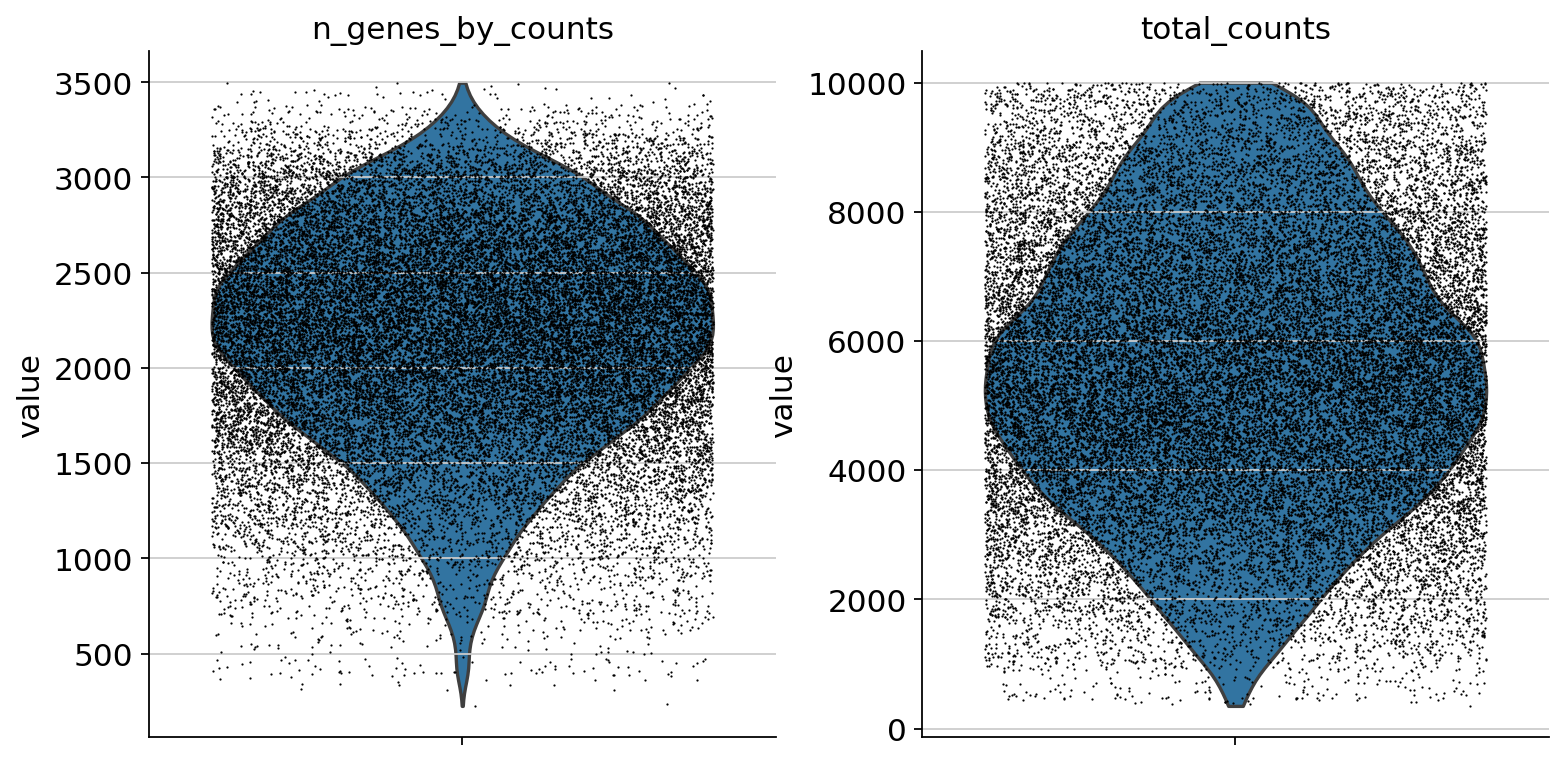

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 4500, :]
adata = adata[adata.obs.total_counts < 15000, :]
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [6]:
adata = adata[adata.obs.celltype == 'ODC',]

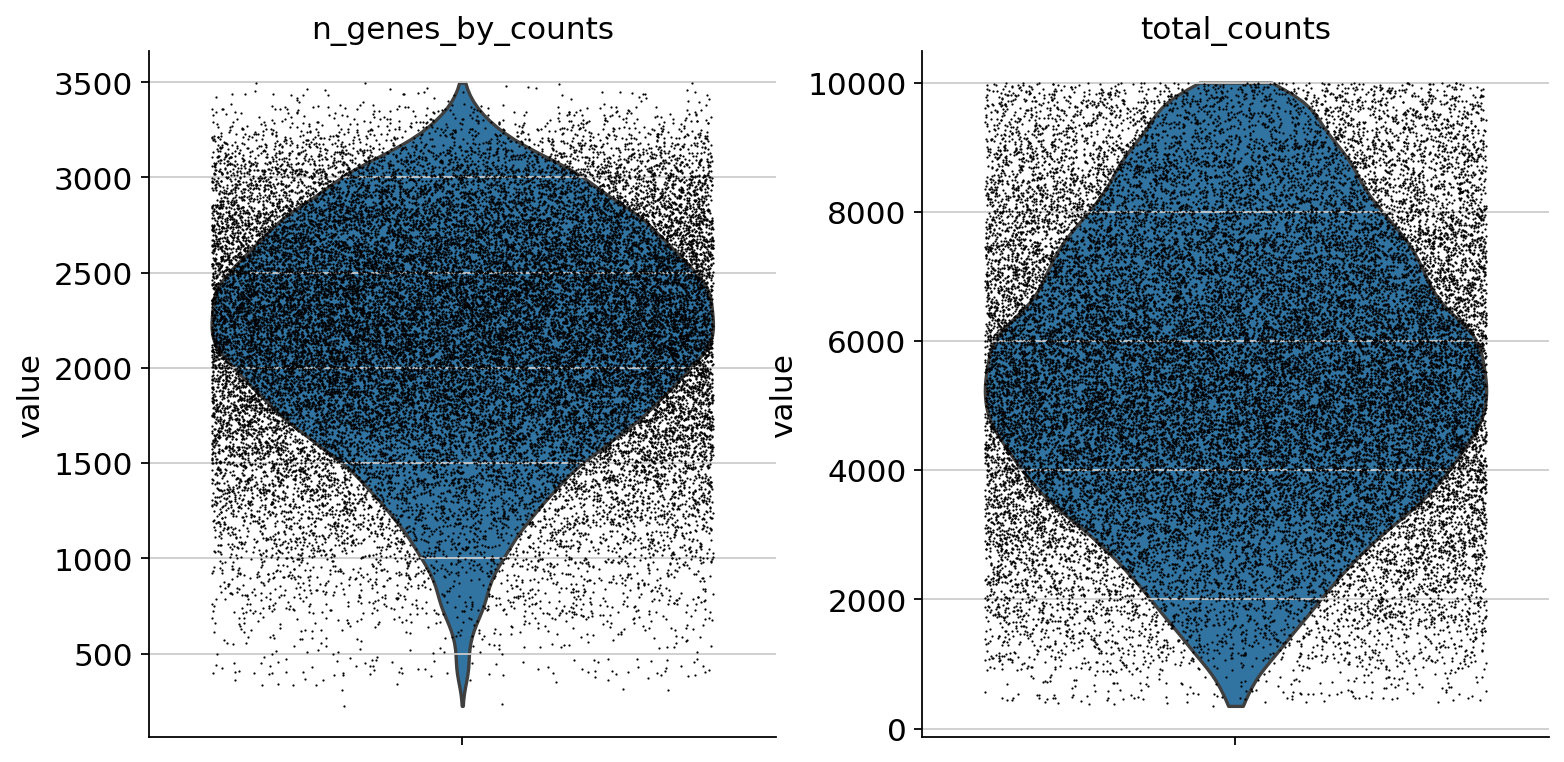

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [8]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata,
    cisTopic_obj = cistopic_obj,
    menr = menr,
    multi_ome_mode = False,
    key_to_group_by = 'Diagnosis',
    nr_cells_per_metacells = 10)

2022-11-23 00:16:52,982 cisTopic     INFO     Imputing drop-outs
2022-11-23 00:16:56,958 cisTopic     INFO     Scaling
2022-11-23 00:17:02,637 cisTopic     INFO     Keep non zero rows
2022-11-23 00:17:08,783 cisTopic     INFO     Imputed accessibility sparsity: 0.2982814029536788
2022-11-23 00:17:08,785 cisTopic     INFO     Create CistopicImputedFeatures object
2022-11-23 00:17:08,786 cisTopic     INFO     Done!
2022-11-23 00:17:08,795 create scenicplus object INFO     Following annotations were found in both assays under key Diagnosis:
	AD, Control.
Keeping 33401 cells for RNA and 9523 for ATAC.
2022-11-23 00:17:33,307 create scenicplus object INFO     Automatically set `nr_metacells` to: AD: 1272, Control: 632
2022-11-23 00:17:33,311 create scenicplus object INFO     Generating pseudo multi-ome data


In [13]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}

import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'hsapiens')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 23617 out of 36066
host: 104
Genes recovered: 23838 out of 36066
host: 103
Genes recovered: 34325 out of 36066
host: 102


/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


Genes recovered: 34418 out of 36066
host: 101
Genes recovered: 34643 out of 36066
host: 100
Genes recovered: 34768 out of 36066
host: 99
Genes recovered: 34905 out of 36066
host: 98
Genes recovered: 35161 out of 36066
host: 97
Genes recovered: 35337 out of 36066
host: 96
Genes recovered: 35496 out of 36066
host: 95
Genes recovered: 35784 out of 36066
host: 94
Genes recovered: 35896 out of 36066
host: 93
Genes recovered: 35306 out of 36066
host: 92
Genes recovered: 35181 out of 36066
host: 91
Genes recovered: 34863 out of 36066
host: 90
Genes recovered: 34687 out of 36066
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 23576 out of 36066
host: 77
Genes recovered: 23044 out of 36066
host: 75
Host not reachable
host: 54
Host not reachable
version: 94 has the largest overlap, use http://oct2018.archive.ensembl.org/ as biomart host


In [9]:
biomart_host = "http://oct2018.archive.ensembl.org/"

In [11]:
# LAST TRY
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    sys.stderr = open(os.path.join(scratch_dir, 'err-odc.log'), "w")
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['Diagnosis'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = os.path.join(local_state_dir, 'TF_names_v_1.01.txt'),
        save_path = os.path.join(scratch_dir, 'scenicplus.v2.odc'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = os.path.join(local_state_dir, 'bin'),
        n_cpu = 20,
        _temp_dir = os.path.join(scratch_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(scratch_dir, 'scenicplus.v2.odc/scplus_obj_f.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-11-23 00:18:57,681 SCENIC+_wrapper INFO     /scratch/leuven/338/vsc33838/scenicplus.v2.odc folder already exists.
2022-11-23 00:18:57,682 SCENIC+_wrapper INFO     Merging cistromes
2022-11-23 00:24:18,624 SCENIC+_wrapper INFO     Getting search space
2022-11-23 00:24:19,840 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl
2022-11-23 00:24:36,180 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2022-11-23 00:24:37,679 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-11-23 00:24:39,841 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-11-23 00:24:53,760 R2G          INFO     Intersecting with regions.
2022-11-23 00:24:54,503 R2G          INFO     Calculating distances from region to gene
2

... storing 'Diagnosis' as categorical


2022-11-23 02:05:43,977 SCENIC+      INFO     Finished calculating DEGs for variable Diagnosis
2022-11-23 02:05:43,978 SCENIC+      INFO     Calculating DARs for variable Diagnosis
2022-11-23 02:05:52,886 SCENIC+      INFO     There are 48740 variable features


... storing 'Diagnosis' as categorical


2022-11-23 02:06:05,655 SCENIC+      INFO     Finished calculating DARs for variable Diagnosis
2022-11-23 02:06:05,659 SCENIC+_wrapper INFO     Exporting to loom file
2022-11-23 02:06:05,660 SCENIC+      INFO     Formatting data
2022-11-23 02:06:06,846 SCENIC+      INFO     Creating minimal loom
2022-11-23 02:06:12,710 SCENIC+      INFO     Adding annotations
2022-11-23 02:06:14,555 SCENIC+      INFO     Adding clusterings
2022-11-23 02:06:14,565 SCENIC+      INFO     Adding markers
2022-11-23 02:06:14,760 SCENIC+      INFO     Exporting
2022-11-23 02:06:19,867 SCENIC+      INFO     Formatting data
2022-11-23 02:06:40,392 SCENIC+      INFO     Creating minimal loom
2022-11-23 02:07:54,090 SCENIC+      INFO     Adding annotations
2022-11-23 02:08:12,349 SCENIC+      INFO     Adding clusterings
2022-11-23 02:08:12,361 SCENIC+      INFO     Adding markers
2022-11-23 02:08:13,987 SCENIC+      INFO     Exporting
2022-11-23 02:09:20,725 SCENIC+_wrapper INFO     Exporting to UCSC
2022-11-23 0

# Checkpoint

In [12]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 6342 x 36066 and n_cells x n_regions = 6342 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'Diagnosis'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [ ]:
import dill
scplus_obj = dill.load(open(os.path.join(scratch_dir, 'scenicplus.v2.odc/scplus_obj.pkl'), 'rb'))

In [12]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 1904 x 30959 and n_cells x n_regions = 1904 x 268952
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'Diagnosis'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

# Downstream Analysis

In [13]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ATF1_+_(33r),ATF1_+_(31g),ATF1,False,chr6:73521014-73521514,SLC17A5,0.048998,0.115333,0.005651,0.005651,0.677791,1,0.093300,0.063238,0.063238,ATF1_+_+
1,ATF1_+_(33r),ATF1_+_(31g),ATF1,False,chr4:88284461-88284961,PPM1K,0.090887,0.212385,0.019303,0.019303,2.007232,1,0.087249,0.175130,0.175130,ATF1_+_+
2,ATF1_+_(33r),ATF1_+_(31g),ATF1,False,chr3:107927450-107927950,BBX,0.025311,0.156890,0.003971,0.003971,1.278549,1,0.122118,0.156134,0.156134,ATF1_+_+
3,ATF1_+_(33r),ATF1_+_(31g),ATF1,False,chr2:241810913-241811413,ATG4B,0.028938,0.126021,0.003647,0.003647,1.289173,1,0.069166,0.089167,0.089167,ATF1_+_+
4,ATF1_+_(33r),ATF1_+_(31g),ATF1,False,chr10:110919064-110919564,BBIP1,0.028699,0.062795,0.001802,0.001802,1.870845,1,0.088100,0.164822,0.164822,ATF1_+_+


In [14]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(scratch_dir, 'scenicplus.v2.odc/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(scratch_dir, 'scenicplus.v2.odc/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

In [15]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 1904 x 30959 and n_cells x n_regions = 1904 x 268952
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'Diagnosis'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [16]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF ATF1 in context frozenset({'positive r2g', '0.85 quantile', '0.95 quantile', '0.9 quantile', 'Top 5 region-to-gene links per gene', 'positive tf2g', 'Cistromes_Unfiltered'}).
 	This eRegulon has 33 target regions and 31 target genes.,
 eRegulon for TF ATF4 in context frozenset({'positive r2g', '0.85 quantile', 'Top 5 region-to-gene links per gene', 'positive tf2g', 'Cistromes_Unfiltered'}).
 	This eRegulon has 19 target regions and 14 target genes.,
 eRegulon for TF ATF6 in context frozenset({'positive r2g', '0.85 quantile', '0.95 quantile', 'Top 15 region-to-gene links per gene', '0.9 quantile', 'Top 10 region-to-gene links per gene', 'Top 5 region-to-gene links per gene', 'BASC binarized', 'positive tf2g', 'Cistromes_Unfiltered'}).
 	This eRegulon has 88 target regions and 70 target genes.,
 eRegulon for TF BCL6 in context frozenset({'positive r2g', 'Top 15 region-to-gene links per gene', 'Top 10 region-to-gene links per gene', 'Top 5 region-to-gene links per gene', 

In [17]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")


cistrome_name: ATF1_(6294r)
context: frozenset({'positive r2g', '0.85 quantile', '0.95 quantile', '0.9 quantile', 'Top 5 region-to-gene links per gene', 'positive tf2g', 'Cistromes_Unfiltered'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 31
n_target_regions: 33
regions2genes: [r2g(region='chr6:73521014-73521514', target='SLC17A5', importance=0.048997732959324476, rho=0.11533270449244436, importance_x_rho=0.005651041056197471, importance_x_abs_rho=0.005651041056197471), r2g(region='chr4:88284461-88284961', target='PPM1K', importance=0.09088697257316719, rho=0.2123851058886457, importance_x_rho=0.019303039293850553, importance_x_abs_rho=0.019303039293850553), r2g(region='chr3:107927450-107927950', target='BBX', importance=0.025310800875568765, rho=0.15688950481253156, importance_x_rho=0.003970999015776574, importance_x_abs_rho=0.003970999015776574), r2g(region='chr2:241810913-241811413', target='ATG4B', importa

In [18]:
scplus_obj.metadata_cell

,Diagnosis
AD_0,AD
AD_1,AD
AD_2,AD
AD_3,AD
AD_4,AD
...,...
Control_627,Control
Control_628,Control
Control_629,Control
Control_630,Control


In [19]:
scplus_obj.uns['eRegulon_AUC_filtered']['Gene_based']

,PBX3_+_(174g),ZNF451_extended_+_(51g),MAFF_+_(10g),E2F5_+_(22g),ZNF565_+_(233g),CLOCK_+_(23g),TFCP2_+_(26g),SREBF2_+_(226g),ZBTB44_+_(43g),ZBTB20_+_(148g),...,ZNF764_extended_+_(15g),THRA_+_(26g),NFKB1_+_(78g),STAT5B_+_(54g),LCORL_+_(20g),MECP2_+_(50g),SOX7_+_(10g),KLF15_extended_-_(12g),EGR1_+_(61g),ZNF684_+_(11g)
Cell,,,,,,,,,,,,,,,,,,,,,
AD_0,0.302972,0.226618,0.124612,0.130315,0.280306,0.229609,0.480024,0.357301,0.324575,0.430765,...,0.114599,0.267417,0.285356,0.320748,0.227455,0.284005,0.180814,0.386143,0.090725,0.308551
AD_1,0.297844,0.230544,0.205103,0.159032,0.326269,0.233682,0.416667,0.340779,0.349108,0.450215,...,0.067571,0.289704,0.330103,0.390301,0.319832,0.265724,0.100646,0.216085,0.124137,0.415081
AD_2,0.300621,0.250279,0.224612,0.154686,0.298558,0.259802,0.398256,0.345930,0.363064,0.445592,...,0.084927,0.292611,0.316479,0.364867,0.350775,0.303463,0.164147,0.238803,0.147361,0.412908
AD_3,0.284312,0.226871,0.234302,0.121946,0.289469,0.208993,0.474533,0.340273,0.346464,0.432005,...,0.116193,0.296189,0.272817,0.345057,0.290407,0.251421,0.181137,0.285099,0.127399,0.392824
AD_4,0.333337,0.218220,0.246641,0.146171,0.303318,0.207477,0.393088,0.308148,0.366129,0.435715,...,0.078596,0.286623,0.286640,0.401247,0.341537,0.267506,0.156137,0.235304,0.130915,0.387186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Control_627,0.285634,0.227960,0.210724,0.136452,0.268548,0.185541,0.498410,0.355440,0.343684,0.431197,...,0.112489,0.243590,0.283087,0.330307,0.246286,0.264444,0.119509,0.318583,0.112234,0.330691
Control_628,0.301583,0.196104,0.178811,0.119069,0.288968,0.214246,0.468346,0.333762,0.346494,0.430211,...,0.108269,0.266200,0.275823,0.353586,0.314922,0.224173,0.147674,0.370478,0.150093,0.302913
Control_629,0.273412,0.260906,0.168152,0.101304,0.275590,0.215201,0.450358,0.352850,0.310724,0.437954,...,0.099182,0.200084,0.250994,0.330235,0.291925,0.248333,0.154716,0.361219,0.102967,0.364106


In [20]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'Diagnosis',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based',
        nr_cells = 50,
        nr_pseudobulks = 10)
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'Diagnosis',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based',
        nr_cells = 50,
        nr_pseudobulks = 10)

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'Diagnosis',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'Diagnosis',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [21]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']

0                PBX3_+_(206r)
1      ZNF451_extended_+_(52r)
2                 MAFF_+_(12r)
3                 E2F5_+_(26r)
4              ZNF565_+_(309r)
                ...           
96                SOX7_+_(10r)
97      KLF15_extended_-_(35r)
98               MECP2_+_(50r)
99               EGR1_+_(121r)
100             ZNF684_+_(12r)
Name: Cistrome, Length: 100, dtype: object

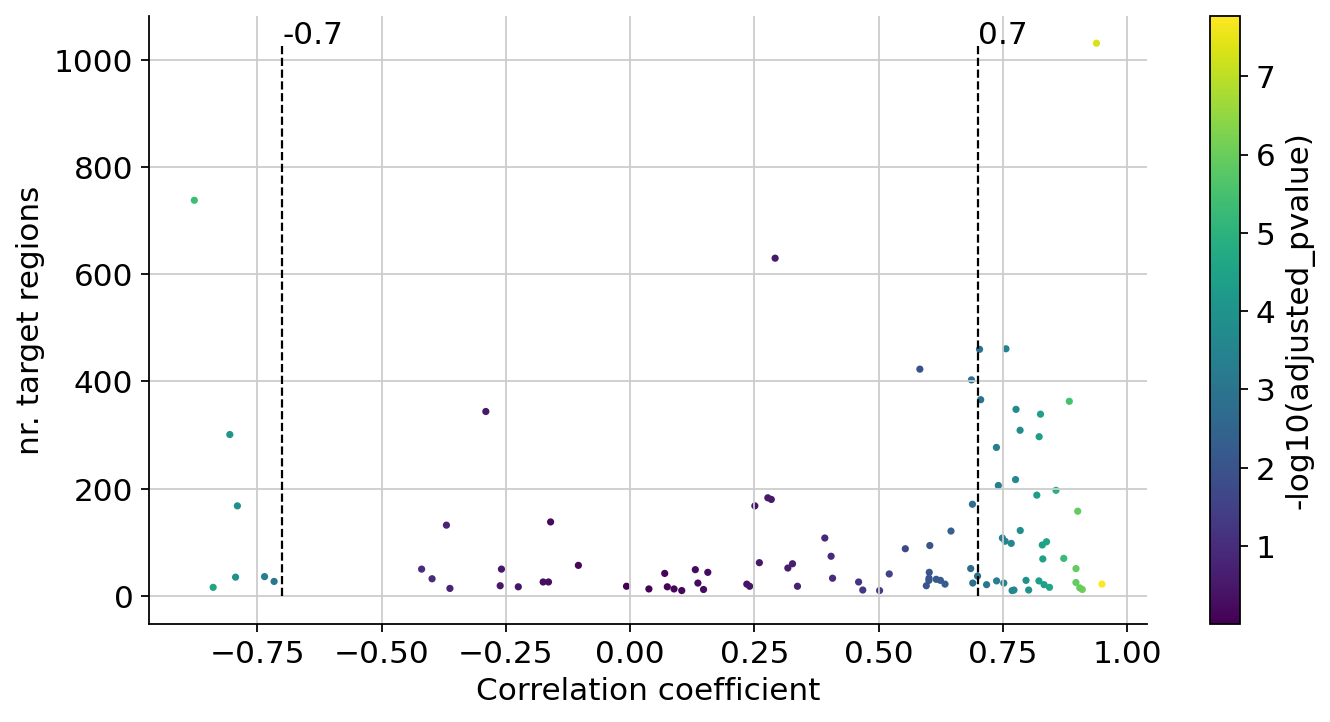

In [22]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.7, 0.70],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [23]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 45 eRegulons


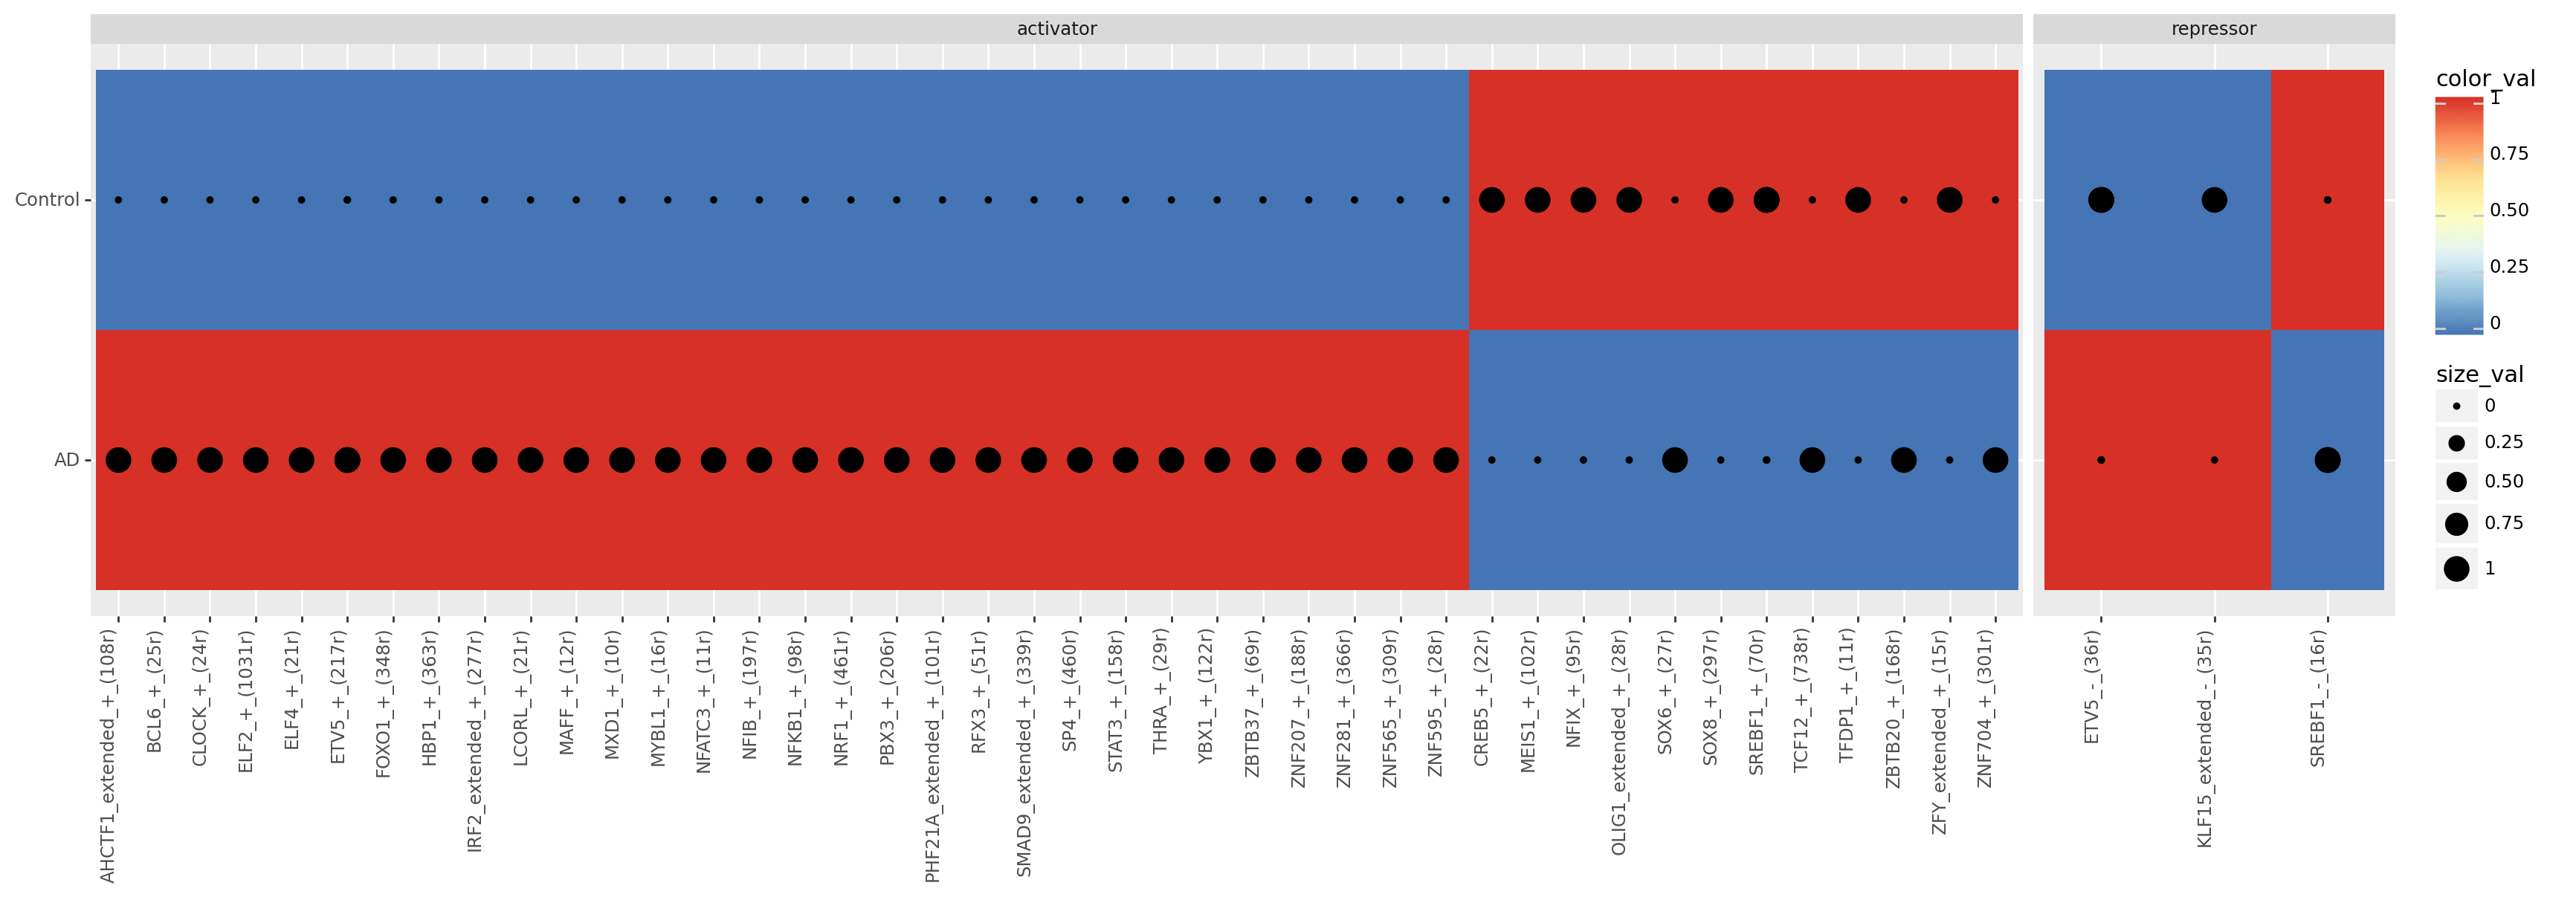

<ggplot: (1449926647923)>

In [25]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'Diagnosis',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        # index_order = ['MM001', 'MM011', 'MM031', 'MM087', 'MM074', 'MM057', 'MM047', 'MM029', 'MM099'],
        figsize = (20, 5),
        orientation = 'horizontal')

In [ ]:
# Gene based
%matplotlib inline
sns.set_style("white")
colors = ["#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF"]
categories = sorted(set(scplus_obj.metadata_cell['Diagnosis']))
color_dict = dict(zip(categories, colors[0:len(categories)]))
prune_plot(scplus_obj,
           'SOX5',
           pseudobulk_variable = 'Diagnosis',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           auc_key = 'eRegulon_AUC_filtered',
           signature_key = 'Gene_based',
           seed=555)

In [ ]:
from scenicplus.plotting.correlation_plot import *
correlation_heatmap(scplus_obj,
                    auc_key = 'eRegulon_AUC_filtered',
                    signature_keys = ['Gene_based'],
                    selected_regulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
                    fcluster_threshold = 0.1,
                    fontsize = 6)

In [ ]:
#from scenicplus.plotting.correlation_plot import *
jaccard_heatmap(scplus_obj,
                    gene_or_region_based = 'Gene_based',
                    signature_key = 'eRegulon_signatures_filtered',
                    selected_regulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
                    fcluster_threshold = 0.1,
                    fontsize = 3,
                    method='intersect')

In [ ]:
scplus_obj.uns['selected_eRegulon']

In [ ]:
dill.dump(scplus_obj, open(os.path.join(scratch_dir, 'scenicplus.v2.odc/scplus_obj_pseudo.pkl'), 'wb'), protocol=-1)

In [19]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 5768 x 36066 and n_cells x n_regions = 5768 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'celltype'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [35]:
from pycisTopic.diff_features import find_highly_variable_features
hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Region']))], n_top_features=5000, plot = False)
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features=2300, plot = False)

2022-11-23 09:55:55,962 cisTopic     INFO     Calculating mean
2022-11-23 09:55:55,973 cisTopic     INFO     Calculating variance
2022-11-23 09:55:56,088 cisTopic     INFO     Done!
2022-11-23 09:55:56,124 cisTopic     INFO     Calculating mean
2022-11-23 09:55:56,128 cisTopic     INFO     Calculating variance
2022-11-23 09:55:56,212 cisTopic     INFO     Done!


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [ ]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
nx_tables = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
    subset_eRegulons = ['MYRF', 'HBP1', 'ZBTB20', 'SOX10'],
    subset_regions = hvr,
    subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True,
    differential_variable = ['Diagnosis'])

In [ ]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables,
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'MYRF': 'Orange', 'HBP1': 'Green', 'ZBTB20': 'Purple', 'SOX10': 'Black'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'MYRF': 'Orange', 'HBP1': 'Green', 'ZBTB20': 'Purple', 'SOX10': 'Black'}},
                                    'Gene': {'variable': 'GEX_celltype_Log2FC_ODC', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'GEX_celltype_Log2FC_ODC', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'GEX_celltype_Log2FC_ODC', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'GEX_celltype_Log2FC_ODC', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=250)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plot_networkx(G, pos)